# Loss v/s Epochs

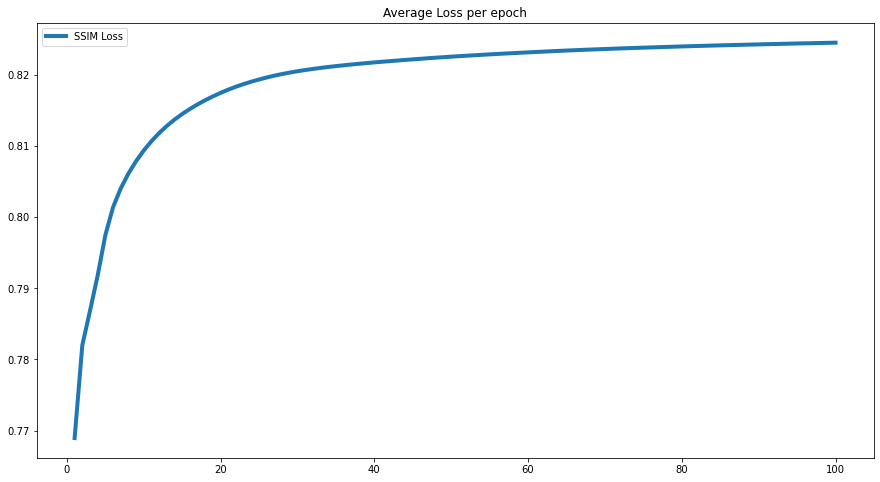

Time taken per epoch: 630.90s


In [11]:
import os
import re
import numpy as np

root_dir = "."
name = "dedrop"

with open(os.path.join(root_dir, name, "output.log")) as f:
    outputs = f.readlines()

epochs, time, loss = [], [], []
for line in outputs:
    s = re.search('^[a-zA-Z ]+([\d]+)[a-zA-Z ]+:[a-zA-Z ]+= ([\d.]+),[a-zA-Z ]+= -([\d.]+)', line)
    if s is not None:
        epochs.append(int(s.group(1)))
        time.append(float(s.group(2)))
        loss.append(float(s.group(3)))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
plt.plot(epochs, loss, linewidth=4)
plt.title("Average Loss per epoch")
plt.legend(["SSIM Loss"])
plt.show()

print("Time taken per epoch: {:.2f}s".format(np.mean(time)))

# Sample Outputs

In [2]:
import os
import torch
from models import DedropNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DedropNet().to(device)

checkpoint_path = os.path.join(root_dir, name, "checkpoint_latest.tar")
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

DedropNet(
  (vae): VAE(
    (encoder): Encoder(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): ReLU(inplace=True)
        (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (5): ReLU(inplace=True)
        (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (7): ReLU(inplace=True)
        (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
        (9): ReLU(inplace=True)
        (10): View()
        (11): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (decoder): Decoder(
      (main): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): View()
        (2): ReLU(inplace=True)
        (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), strid

In [3]:
from dataset import get_dataset
from torch.utils.data import DataLoader

test_dataset = get_dataset(phase='test_a')
dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [4]:
import torch
import matplotlib.pyplot as plt

def get_patches(input_tensor):
    rows, cols = int(448 / 64), int(704 / 64)
    input_tensor = input_tensor.squeeze()
    patches = []
    for i in range(rows):
        for j in range(cols):
            patches.append(input_tensor[:, i*64:(i+1)*64, j*64:(j+1)*64])
    return torch.stack(patches)

def stitch_patches(patches):
    patch_size = patches.size(2)
    multiplication_factor = 64 / patch_size
    
    height, width = int(448 / multiplication_factor), int(704 / multiplication_factor)
    
    rows, cols = int(height / patch_size), int(width / patch_size)
    
    stitched = torch.zeros(patches.size(1), height, width)
    for index in range(patches.size(0)):
        i, j = int(index / cols), index % cols
        stitched[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = torch.select(patches, 0, index)
    return stitched

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


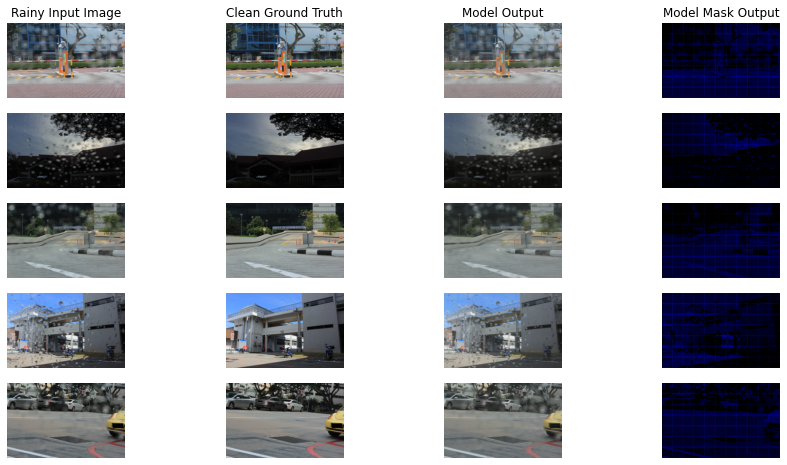

In [10]:
images = 5
fig, ax = plt.subplots(images, 4, figsize=(15, 8))
ax[0][0].set_title("Rainy Input Image")
ax[0][1].set_title("Clean Ground Truth")
ax[0][2].set_title("Model Output")
ax[0][3].set_title("Model Mask Output")

for i in range(images):
    (rain, clean) = next(iter(dataloader))
    rain = rain.to(device)
    clean = clean.to(device)
    patches = get_patches(rain)
    output, _, mask = model(patches)

    output_stitched = stitch_patches(output)
    mask_stitched = stitch_patches(mask)
    ax[i][0].imshow(rain[0].detach().cpu().permute(1, 2, 0))
    ax[i][0].axis('off')
    ax[i][1].imshow(clean[0].detach().cpu().permute(1, 2, 0))
    ax[i][1].axis('off')
    ax[i][2].imshow(output_stitched.detach().cpu().permute(1, 2, 0))
    ax[i][2].axis('off')
    ax[i][3].imshow(mask_stitched.detach().cpu().permute(1, 2, 0))
    ax[i][3].axis('off')
plt.show()

# Test Outputs (Test Set A)

In [14]:
from dataset import get_dataset
from torch.utils.data import DataLoader

test_dataset = get_dataset(phase='test_a')
dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [20]:
import numpy as np
from torch.nn.functional import mse_loss

errors = []
for (rain, clean) in dataloader:
    rain = rain.to(device)
    clean = clean.to(device)
    
    patches = get_patches(rain)
    output, _, mask = model(patches)
    output_stitched = stitch_patches(output)
    
    clean = clean.squeeze()
    assert output_stitched.size() == clean.size()
    mse_error = mse_loss(output_stitched.detach().cpu(), clean.detach().cpu())
    errors.append(mse_error)

print("MSE Error:", np.mean(errors))

MSE Error: 0.006812484


In [22]:
import numpy as np
from ssim import SSIM

errors = []
ssim = SSIM()
for (rain, clean) in dataloader:
    rain = rain.to(device)
    clean = clean.to(device)
    
    patches = get_patches(rain)
    output, _, mask = model(patches)
    output_stitched = stitch_patches(output)
    
    output_stitched = output_stitched.unsqueeze(0)
    assert output_stitched.size() == clean.size()
    ssim_error = ssim(output_stitched.detach().cpu(), clean.detach().cpu())
    errors.append(ssim_error)

print("SSIM Error:", np.mean(errors))

SSIM Error: 0.812318


# Test Outputs (Test Set B)

In [23]:
from dataset import get_dataset
from torch.utils.data import DataLoader

test_dataset = get_dataset(phase='test_b')
dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [25]:
import numpy as np
from torch.nn.functional import mse_loss

errors = []
for (rain, clean) in dataloader:
    rain = rain.to(device)
    clean = clean.to(device)
    
    patches = get_patches(rain)
    output, _, mask = model(patches)
    output_stitched = stitch_patches(output)
    
    clean = clean.squeeze()
    assert output_stitched.size() == clean.size()
    mse_error = mse_loss(output_stitched.detach().cpu(), clean.detach().cpu())
    errors.append(mse_error)

print("MSE Error:", np.mean(errors))

MSE Error: 0.009363451


In [26]:
import numpy as np
from ssim import SSIM

errors = []
ssim = SSIM()
for (rain, clean) in dataloader:
    rain = rain.to(device)
    clean = clean.to(device)
    
    patches = get_patches(rain)
    output, _, mask = model(patches)
    output_stitched = stitch_patches(output)
    
    output_stitched = output_stitched.unsqueeze(0)
    assert output_stitched.size() == clean.size()
    ssim_error = ssim(output_stitched.detach().cpu(), clean.detach().cpu())
    errors.append(ssim_error)

print("SSIM Error:", np.mean(errors))

SSIM Error: 0.74497527
